<a href="https://colab.research.google.com/github/awill139/Demystifying-AI-Course/blob/master/Class_8_more_lstms_and_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To start, here are some supplementary articles, we can go over the first together, and the second is also highly recommented. The second two are extraordinarily in depth where the writer not only gives the formulas, but also derives them by hand

http://arunmallya.github.io/writeups/nn/lstm/index.html#/

https://medium.com/@aidangomez/let-s-do-this-f9b699de31d9

https://towardsdatascience.com/back-to-basics-deriving-back-propagation-on-simple-rnn-lstm-feat-aidan-gomez-c7f286ba973d

https://towardsdatascience.com/only-numpy-deriving-forward-feed-and-back-propagation-in-long-short-term-memory-lstm-part-1-4ee82c14a652

In [0]:
import numpy as np
import os
import time

We will use the Shakespeare text just as we did last time but this time we will use our own network

In [0]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

Let's start with creating the RNN where our LSTMs will live

In [0]:
class RecurrentNeuralNetwork:
    #input (word), expected output (next word), num of words (num of recurrences), array expected outputs, learning rate
    def __init__ (self, xs, ys, rl, eo, lr):
        #initial input (first word)
        self.x = np.zeros(xs)
        #input size 
        self.xs = xs
        #expected output (next word)
        self.y = np.zeros(ys)
        #output size
        self.ys = ys
        #weight matrix for interpreting results from LSTM cell (num words x num words matrix)
        self.w = np.random.random((ys, ys))
        #matrix used in RMSprop
        self.G = np.zeros_like(self.w)
        #length of the recurrent network - number of recurrences i.e num of words
        self.rl = rl
        #learning rate 
        self.lr = lr
        #array for storing inputs
        self.ia = np.zeros((rl+1,xs))
        #array for storing cell states
        self.ca = np.zeros((rl+1,ys))
        #array for storing outputs
        self.oa = np.zeros((rl+1,ys))
        #array for storing hidden states
        self.ha = np.zeros((rl+1,ys))
        #forget gate 
        self.af = np.zeros((rl+1,ys))
        #input gate
        self.ai = np.zeros((rl+1,ys))
        #cell state
        self.ac = np.zeros((rl+1,ys))
        #output gate
        self.ao = np.zeros((rl+1,ys))
        #array of expected output values
        self.eo = np.vstack((np.zeros(eo.shape[0]), eo.T))
        #declare LSTM cell (input, output, amount of recurrence, learning rate)
        self.LSTM = LSTM(xs, ys, rl, lr)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def dsigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))    
    
    #lets apply a series of matrix operations to our input (curr word) to compute a predicted output (next word)
    def forwardProp(self):
        for i in range(1, self.rl+1):
            self.LSTM.x = np.hstack((self.ha[i-1], self.x))
            cs, hs, f, inp, c, o = self.LSTM.forwardProp()
            #store computed cell state
            self.ca[i] = cs
            self.ha[i] = hs
            self.af[i] = f
            self.ai[i] = inp
            self.ac[i] = c
            self.ao[i] = o
            self.oa[i] = self.sigmoid(np.dot(self.w, hs))
            self.x = self.eo[i-1]
        return self.oa
      
    def backProp(self):
        #update our weight matrices (Both in our Recurrent network, as well as the weight matrices inside LSTM cell)
        #init an empty error value 
        totalError = 0
        #initialize matrices for gradient updates
        #First, these are RNN level gradients
        #cell state
        dfcs = np.zeros(self.ys)
        #hidden state
        dfhs = np.zeros(self.ys)
        #weight matrix
        tu = np.zeros((self.ys,self.ys))
        #Next, these are LSTM level gradients
        #forget gate
        tfu = np.zeros((self.ys, self.xs+self.ys))
        #input gate
        tiu = np.zeros((self.ys, self.xs+self.ys))
        #cell unit
        tcu = np.zeros((self.ys, self.xs+self.ys))
        #output gate
        tou = np.zeros((self.ys, self.xs+self.ys))
        #loop backwards through recurrences
        for i in range(self.rl, -1, -1):
            #error = calculatedOutput - expectedOutput
            error = self.oa[i] - self.eo[i]
            #calculate update for weight matrix
            #(error * derivative of the output) * hidden state
            tu += np.dot(np.atleast_2d(error * self.dsigmoid(self.oa[i])), np.atleast_2d(self.ha[i]).T)
            #Time to propagate error back to exit of LSTM cell
            #1. error * RNN weight matrix
            error = np.dot(error, self.w)
            #2. set input values of LSTM cell for recurrence i (horizontal stack of arrays, hidden + input)
            self.LSTM.x = np.hstack((self.ha[i-1], self.ia[i]))
            #3. set cell state of LSTM cell for recurrence i (pre-updates)
            self.LSTM.cs = self.ca[i]
            #Finally, call the LSTM cell's backprop, retreive gradient updates
            #gradient updates for forget, input, cell unit, and output gates + cell states & hiddens states
            fu, iu, cu, ou, dfcs, dfhs = self.LSTM.backProp(error, self.ca[i-1], self.af[i], self.ai[i], self.ac[i], self.ao[i], dfcs, dfhs)
            #calculate total error (not necesarry, used to measure training progress)
            totalError += np.sum(error)
            #accumulate all gradient updates
            #forget gate
            tfu += fu
            #input gate
            tiu += iu
            #cell state
            tcu += cu
            #output gate
            tou += ou
        #update LSTM matrices with average of accumulated gradient updates    
        self.LSTM.update(tfu/self.rl, tiu/self.rl, tcu/self.rl, tou/self.rl) 
        #update weight matrix with average of accumulated gradient updates  
        self.update(tu/self.rl)
        #return total error of this iteration
        return totalError
    
    def update(self, u):
        #vanilla implementation of RMSprop
        self.G = 0.9 * self.G + 0.1 * u**2  
        self.w -= self.lr/np.sqrt(self.G + 1e-8) * u
        return
    
    #this is where we generate some sample text after having fully trained our model
    #i.e error is below some threshold
    def sample(self):
         #loop through recurrences - start at 1 so the 0th entry of all arrays will be an array of 0's
        for i in range(1, self.rl+1):
            #set input for LSTM cell, combination of input (previous output) and previous hidden state
            self.LSTM.x = np.hstack((self.ha[i-1], self.x))
            #run forward prop on the LSTM cell, retrieve cell state and hidden state
            cs, hs, f, inp, c, o = self.LSTM.forwardProp()
            #store input as vector
            maxI = np.argmax(self.x)
            self.x = np.zeros_like(self.x)
            self.x[maxI] = 1
            self.ia[i] = self.x
            #store cell states
            self.ca[i] = cs
            #store hidden state
            self.ha[i] = hs
            #forget gate
            self.af[i] = f
            #input gate
            self.ai[i] = inp
            #cell state
            self.ac[i] = c
            #output gate
            self.ao[i] = o
            #calculate output by multiplying hidden state with weight matrix
            self.oa[i] = self.sigmoid(np.dot(self.w, hs))
            #compute new input
            maxI = np.argmax(self.oa[i])
            newX = np.zeros_like(self.x)
            newX[maxI] = 1
            self.x = newX
        #return all outputs    
        return self.oa

Here are the equations for LSTMs if we forgot, forward prop and backward

![alt text](http://i.imgur.com/BUAVEZg.png "Logo Title Text 1")

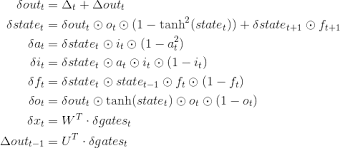

Now we can create the actual LSTM

In [0]:
class LSTM:
    # LSTM cell (input, output, amount of recurrence, learning rate)
    def __init__ (self, xs, ys, rl, lr):
        #input is word length x word length
        self.x = np.zeros(xs+ys)
        #input size is word length + word length
        self.xs = xs + ys
        #output 
        self.y = np.zeros(ys)
        #output size
        self.ys = ys
        #cell state intialized as size of prediction
        self.cs = np.zeros(ys)
        #how often to perform recurrence
        self.rl = rl
        #balance the rate of training (learning rate)
        self.lr = lr
        #init weight matrices for our gates
        #forget gate
        self.f = np.random.random((ys, xs+ys))
        #input gate
        self.i = np.random.random((ys, xs+ys))
        #cell state
        self.c = np.random.random((ys, xs+ys))
        #output gate
        self.o = np.random.random((ys, xs+ys))
        #forget gate gradient
        self.Gf = np.zeros_like(self.f)
        #input gate gradient
        self.Gi = np.zeros_like(self.i)
        #cell state gradient
        self.Gc = np.zeros_like(self.c)
        #output gate gradient
        self.Go = np.zeros_like(self.o)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def dsigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tangent(self, x):
        return np.tanh(x)
    
    #derivative for computing gradients
    def dtangent(self, x):
        return 1 - np.tanh(x)**2
    
    #lets compute a series of matrix multiplications to convert our input into our output
    def forwardProp(self):
        f = self.sigmoid(np.dot(self.f, self.x))
        self.cs *= f
        i = self.sigmoid(np.dot(self.i, self.x))
        c = self.tangent(np.dot(self.c, self.x))
        self.cs += i * c
        o = self.sigmoid(np.dot(self.o, self.x))
        self.y = o * self.tangent(self.cs)
        return self.cs, self.y, f, i, c, o
    
    
    def backProp(self, e, pcs, f, i, c, o, dfcs, dfhs):
        #error = error + hidden state derivative. clip the value between -6 and 6.
        e = np.clip(e + dfhs, -6, 6)
        #multiply error by activated cell state to compute output derivative
        do = self.tangent(self.cs) * e
        #output update = (output deriv * activated output) * input
        ou = np.dot(np.atleast_2d(do * self.dtangent(o)).T, np.atleast_2d(self.x))
        #derivative of cell state = error * output * deriv of cell state + deriv cell
        dcs = np.clip(e * o * self.dtangent(self.cs) + dfcs, -6, 6)
        #deriv of cell = deriv cell state * input
        dc = dcs * i
        #cell update = deriv cell * activated cell * input
        cu = np.dot(np.atleast_2d(dc * self.dtangent(c)).T, np.atleast_2d(self.x))
        #deriv of input = deriv cell state * cell
        di = dcs * c
        #input update = (deriv input * activated input) * input
        iu = np.dot(np.atleast_2d(di * self.dsigmoid(i)).T, np.atleast_2d(self.x))
        #deriv forget = deriv cell state * all cell states
        df = dcs * pcs
        #forget update = (deriv forget * deriv forget) * input
        fu = np.dot(np.atleast_2d(df * self.dsigmoid(f)).T, np.atleast_2d(self.x))
        #deriv cell state = deriv cell state * forget
        dpcs = dcs * f
        #deriv hidden state = (deriv cell * cell) * output + deriv output * output * output deriv input * input * output + deriv forget
        #* forget * output
        dphs = np.dot(dc, self.c)[:self.ys] + np.dot(do, self.o)[:self.ys] + np.dot(di, self.i)[:self.ys] + np.dot(df, self.f)[:self.ys] 
        #return update gradinets for forget, input, cell, output, cell state, hidden state
        return fu, iu, cu, ou, dpcs, dphs
            
    def update(self, fu, iu, cu, ou):
        #update forget, input, cell, and output gradients
        self.Gf = 0.9 * self.Gf + 0.1 * fu**2 
        self.Gi = 0.9 * self.Gi + 0.1 * iu**2   
        self.Gc = 0.9 * self.Gc + 0.1 * cu**2   
        self.Go = 0.9 * self.Go + 0.1 * ou**2   
        
        #update our gates using our gradients
        self.f -= self.lr/np.sqrt(self.Gf + 1e-8) * fu
        self.i -= self.lr/np.sqrt(self.Gi + 1e-8) * iu
        self.c -= self.lr/np.sqrt(self.Gc + 1e-8) * cu
        self.o -= self.lr/np.sqrt(self.Go + 1e-8) * ou
        return

In [0]:
def LoadText():
    #open text and return input and output data (series of words)
    with open("shakespeare.txt", "r") as text_file:
        data = text_file.read()
    text = list(data)
    outputSize = len(text)
    data = list(set(text))
    uniqueWords, dataSize = len(data), len(data) 
    returnData = np.zeros((uniqueWords, dataSize))
    for i in range(0, dataSize):
        returnData[i][i] = 1
    returnData = np.append(returnData, np.atleast_2d(data), axis=0)
    output = np.zeros((uniqueWords, outputSize))
    for i in range(0, outputSize):
        index = np.where(np.asarray(data) == text[i])
        output[:,i] = returnData[0:-1,index[0]].astype(float).ravel()  
    return returnData, uniqueWords, output, outputSize, data

#write the predicted output (series of words) to disk
def ExportText(output, data):
    finalOutput = np.zeros_like(output)
    prob = np.zeros_like(output[0])
    outputText = ""
    print(len(data))
    print(output.shape[0])
    for i in range(0, output.shape[0]):
        for j in range(0, output.shape[1]):
            prob[j] = output[i][j] / np.sum(output[i])
        outputText += np.random.choice(data, p=prob)    
    with open("output.txt", "w") as text_file:
        text_file.write(outputText)
    return

In [0]:
#Begin program    
print("Beginning")
iterations = 5000
learningRate = 0.001
#load input output data (words)
returnData, numCategories, expectedOutput, outputSize, data = LoadText()
print("Done Reading")
#init our RNN using our hyperparams and dataset
RNN = RecurrentNeuralNetwork(numCategories, numCategories, outputSize, expectedOutput, learningRate)

#training time!
for i in range(1, iterations):
    #compute predicted next word
    RNN.forwardProp()
    #update all our weights using our error
    error = RNN.backProp()
    #once our error/loss is small enough
    print("Error on iteration ", i, ": ", error)
    if error > -100 and error < 100 or i % 100 == 0:
        #we can finally define a seed word
        seed = np.zeros_like(RNN.x)
        maxI = np.argmax(np.random.random(RNN.x.shape))
        seed[maxI] = 1
        RNN.x = seed  
        #and predict some new text!
        output = RNN.sample()
        print(output)    
        #write it all to disk
        ExportText(output, data)
        print("Done Writing")
print("Complete")

So now I would like to introduce autoencoders

In [0]:
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import LSTMCell

import numpy as np


class LSTMAutoencoder(object):
    def __init__(
        self,
        hidden_num,
        inputs,
        cell=None,
        optimizer=None,
        reverse=True,
        decode_without_input=False,
        ):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]

        if cell is None:
            self._enc_cell = LSTMCell(hidden_num)
            self._dec_cell = LSTMCell(hidden_num)
        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight'
                    )
            dec_bias_ = tf.Variable(tf.constant(0.1,
                                    shape=[self.elem_num],
                                    dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),
                              dtype=tf.float32) for _ in
                              range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state,
                        dtype=tf.float32)
                if reverse:
                    dec_outputs = dec_outputs[::-1]
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,
                        2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),
                        [self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_
                
            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),
                        dtype=tf.float32)
                dec_outputs = []
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) = \
                        self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) \
                        + dec_bias_
                    dec_outputs.append(dec_input_)
                if reverse:
                    dec_outputs = dec_outputs[::-1]
                self.output_ = tf.transpose(tf.stack(dec_outputs), [1,
                        0, 2])

        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_
                                   - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)
        else:
            self.train = optimizer.minimize(self.loss)

In [0]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)


# Constants
batch_num = 128
hidden_num = 12
step_num = 8
elem_num = 1
iteration = 10000

# placeholder list
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
ae = LSTMAutoencoder(hidden_num, p_inputs, cell=cell, decode_without_input=True)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(iteration):
        """Random sequences.
          Every sequence has size batch_num * step_num * elem_num 
          Each step number increases 1 by 1.
          An initial number of each sequence is in the range from 0 to 19.
          (ex. [8. 9. 10. 11. 12. 13. 14. 15])
        """
        r = np.random.randint(20, size=batch_num).reshape([batch_num, 1, 1])
        r = np.tile(r, (1, step_num, elem_num))
        d = np.linspace(0, step_num, step_num, endpoint=False).reshape([1, step_num, elem_num])
        d = np.tile(d, (batch_num, 1, 1))
        random_sequences = r + d

        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: random_sequences})
        print('iter %d:' % (i + 1), loss_val)

    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: r + d})
    print('train result :')
    print('input :', input_[0, :, :].flatten())
    print('output :', output_[0, :, :].flatten())

W0619 23:08:41.279132 139627762706304 deprecation.py:323] From <ipython-input-2-e09eccd8805d>:20: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0619 23:08:43.343690 139627762706304 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0619 23:08:43.345010 139627762706304 deprecation.py:323] From <ipython-input-1-2a0006164d10>:29: static_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use 

iter 1: 184.08911
iter 2: 198.07335
iter 3: 197.84373
iter 4: 204.35544
iter 5: 194.08359
iter 6: 207.3706
iter 7: 169.3867
iter 8: 192.55432
iter 9: 193.10187
iter 10: 199.10075
iter 11: 180.86308
iter 12: 205.70953
iter 13: 192.4335
iter 14: 191.2665
iter 15: 180.19292
iter 16: 162.38303
iter 17: 185.9344
iter 18: 203.01418
iter 19: 198.7667
iter 20: 181.91014
iter 21: 168.5455
iter 22: 186.9281
iter 23: 180.89146
iter 24: 185.23863
iter 25: 178.82785
iter 26: 174.69662
iter 27: 175.8982
iter 28: 174.41422
iter 29: 188.64029
iter 30: 174.19539
iter 31: 171.57753
iter 32: 183.48723
iter 33: 167.82414
iter 34: 191.29898
iter 35: 181.80614
iter 36: 174.87802
iter 37: 178.24924
iter 38: 162.45467
iter 39: 171.10345
iter 40: 156.35985
iter 41: 188.85318
iter 42: 145.6242
iter 43: 174.58537
iter 44: 163.67934
iter 45: 173.9803
iter 46: 154.67036
iter 47: 141.52216
iter 48: 175.8359
iter 49: 143.52649
iter 50: 134.08968
iter 51: 152.65623
iter 52: 157.77818
iter 53: 130.78265
iter 54: 130.5

This isn't anything special, encoding a random number and decoding it to be within 1 of its original value, but if we think about what we want the ending representation to be, we can encroach on machine translation as well as natual language understanding

And here is the official google tensorflow tutorial for, what is essentially using autoencoders for translating english to spanish

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural Machine Translation with Attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/site/en/r2/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 mintues to run on a single P100 GPU.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [0]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [0]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [0]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [0]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
7 ----> es
65 ----> solo
21 ----> una
500 ----> broma
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
18 ----> m
70 ----> just
634 ----> kidding
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://www.tensorflow.org/tutorials/seq2seq). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://www.tensorflow.org/tutorials/seq2seq#background_on_the_attention_mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5906
Epoch 1 Batch 100 Loss 2.2279
Epoch 1 Batch 200 Loss 1.7181
Epoch 1 Batch 300 Loss 1.6702
Epoch 1 Loss 2.0020
Time taken for 1 epoch 66.82819938659668 sec

Epoch 2 Batch 0 Loss 1.5576
Epoch 2 Batch 100 Loss 1.4791
Epoch 2 Batch 200 Loss 1.3159
Epoch 2 Batch 300 Loss 1.3069
Epoch 2 Loss 1.3782
Time taken for 1 epoch 41.355170011520386 sec

Epoch 3 Batch 0 Loss 1.2020
Epoch 3 Batch 100 Loss 1.0666
Epoch 3 Batch 200 Loss 0.9912
Epoch 3 Batch 300 Loss 0.9965
Epoch 3 Loss 1.0114
Time taken for 1 epoch 40.364017724990845 sec

Epoch 4 Batch 0 Loss 0.8289
Epoch 4 Batch 100 Loss 0.6773
Epoch 4 Batch 200 Loss 0.7134
Epoch 4 Batch 300 Loss 0.7021
Epoch 4 Loss 0.6916
Time taken for 1 epoch 41.19345474243164 sec

Epoch 5 Batch 0 Loss 0.5804
Epoch 5 Batch 100 Loss 0.4383
Epoch 5 Batch 200 Loss 0.4659
Epoch 5 Batch 300 Loss 0.4925
Epoch 5 Loss 0.4585
Time taken for 1 epoch 40.409194469451904 sec

Epoch 6 Batch 0 Loss 0.3540
Epoch 6 Batch 100 Loss 0.2888
Epoch 6 Batch 200 L

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s too cold here . <end> 


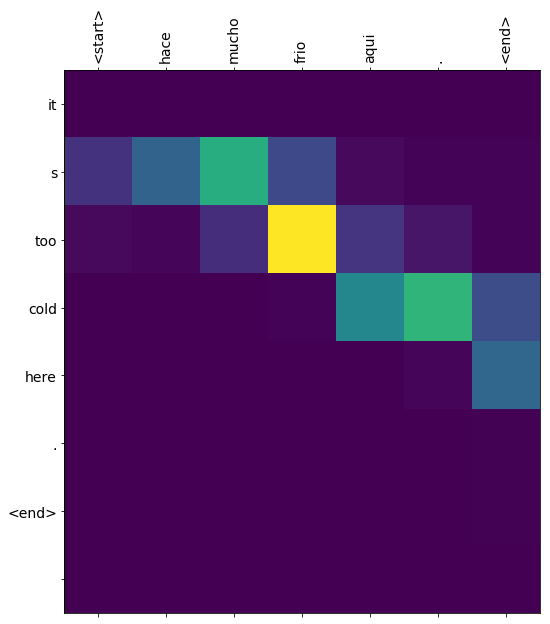

In [0]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


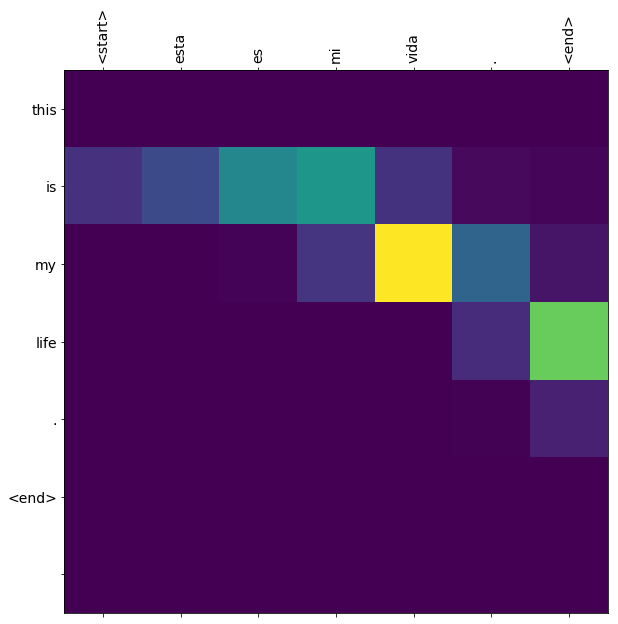

In [0]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


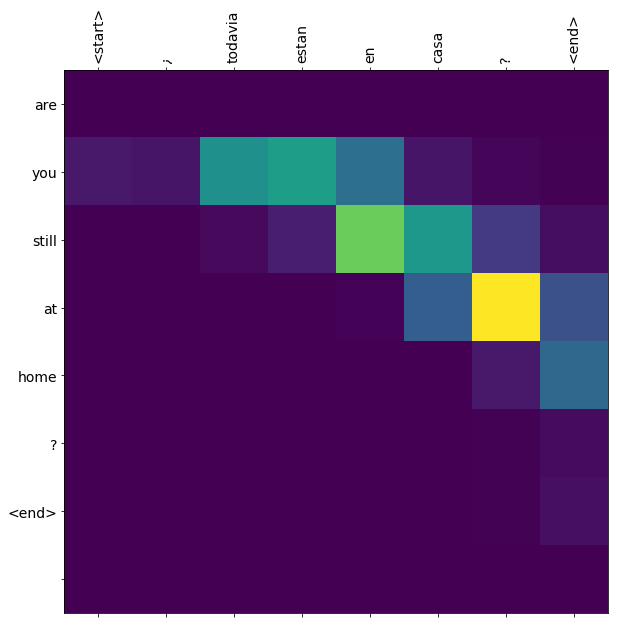

In [0]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


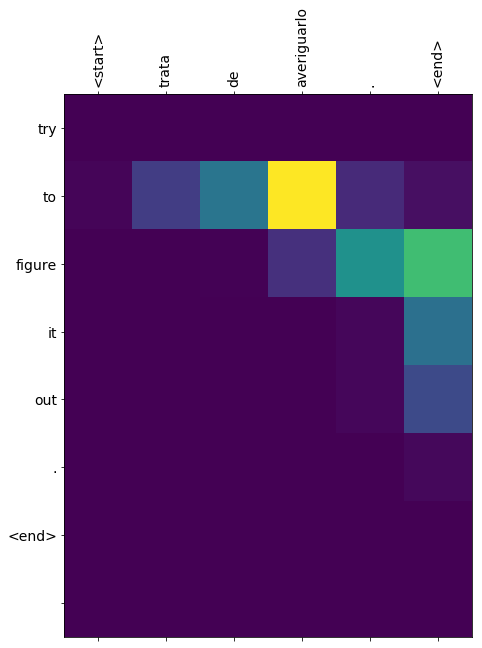

In [0]:
# wrong translation
translate(u'trata de averiguarlo.')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
